## E2 - Stochastic Break Sampling in 2D 
In our first experiment, we performed random folding of 1,000 neutralized 1D strings of proteins, for lengths {5,10,15,…,95,200\}, on a 2D lattice, void of any prior assumptions. This 2D lattice was designed to be twice the size of the maximum amino acid sequence to ensure enough space for the protein to fold. We termed the process ‘neutralization’ because it disregards the hydrophobic and polar labels from the amino acids as shown in Figure 1 of the thesis. This underscores our focus on valid conformations over optimal ones, aligning with the methods described in previous work.

Our methodology began with the central placement of the first amino acid on the grid which is denoted with *{Start (S)}*  `*`, since it has no relative direction towards other acids. From here, the sequential placement of amino acids commenced. Each amino acid was positioned one after another, adhering to a chain-relative representation. Specifically, each subsequent placement randomly selected a position from the set *{left (L), right (R), straight (S)}*, while diligently avoiding any backward or neighbouring collisions by checking empty adjacent grid locations. This chain-relative approach ensured that every subsequent amino acid was next to the preceding one. We maintained a count of the total number of amino acids  each time an amino acid was positioned on the 2D lattice. This process was iterated upon until no valid adjacent locations remained, as visualized in the Figure 2b below.

`*` After generating proteins but before saving the directional data, the first two 'fixed' directions are removed for all proteins.

In [1]:
import numpy as np 
import pandas as pd
import time as time
np.set_printoptions(threshold=np.inf)

/Users/jessekommandeur/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Step 1 - Initializing Acids

This function `random_division` takes the total number of amino acids as input and randomly divides them into hydrophobic and polar amino acids, before creating a random 1D amino acid string. It ensures that there's at least one hydrophobic and one polar amino acid. You can adjust the total_amino_acids variable to the desired number of amino acids you want to divide.

In [2]:
total_amino_acids = 5  # Change this to a desired number, 10 is used for illustration purposes

def random_division(total_amino_acids):
    num_hydrophobic = np.random.randint(1, total_amino_acids)  # Ensure at least one H and P
    num_polar = total_amino_acids - num_hydrophobic
    # randomly shuffle the amino acids
    amino_acids = ['H'] * num_hydrophobic + ['P'] * num_polar
    np.random.shuffle(amino_acids)
    return num_hydrophobic, num_polar, amino_acids

num_hydrophobic, num_polar, amino_acids = random_division(total_amino_acids)
print("Number of Hydro acids:", num_hydrophobic)
print("Number of Polar acids:", num_polar)
print("Random Amino Acid String:", "".join(amino_acids))

Number of Hydro acids: 4
Number of Polar acids: 1
Random Amino Acid String: HHPHH


### Step 2 - Initializing Grid
The `initialize_grid` function generates a grid to place amino acids, with specified dimensions, and populates it with H and P amino acids, while ensuring they do not overlap and tracks their placement order. This allows for simulating the random arrangement of amino acids on a grid for various applications.

In [3]:
amino_acids_copy = amino_acids.copy()

def initialize_grid(amino_acids, num_hydrophobic, num_polar):
    amino_acids_copy = amino_acids.copy()
    total_amino_acids = len(amino_acids)
    grid_size = total_amino_acids * 2
    grid = np.full((grid_size, grid_size), fill_value='', dtype=object)  
    amino_acid_order = []  # List to track the order of amino acids placed
    
    # Place the first amino acid randomly on the grid
    first_amino_row = grid_size // 2
    first_amino_col = grid_size // 2
    amino_acid_type = amino_acids_copy.pop(0)
    grid[first_amino_row, first_amino_col] = amino_acid_type
    
    # Keep track of order
    amino_acid_order.append((amino_acid_type, (first_amino_row, first_amino_col)))
    total_amino_acids -= 1
    
    # Place the remaining amino acids next to the last placed amino acid
    while total_amino_acids > 0:
        last_amino_row, last_amino_col = amino_acid_order[-1][1]
        neighbors = [
            (last_amino_row - 1, last_amino_col),
            (last_amino_row + 1, last_amino_col),
            (last_amino_row, last_amino_col - 1),
            (last_amino_row, last_amino_col + 1)
        ]
        
        valid_neighbors = [(row, col) for row, col in neighbors if 0 <= row < grid_size and 0 <= col < grid_size and grid[row, col] == '']
        
        if valid_neighbors and amino_acids_copy:  # Check if there are valid neighbors and remaining amino acids
            # Shuffle the list of valid neighbors and choose one randomly
            np.random.shuffle(valid_neighbors)
            chosen_row, chosen_col = valid_neighbors[0]
            amino_acid_type = amino_acids_copy.pop(0)
            grid[chosen_row, chosen_col] = amino_acid_type
            amino_acid_order.append((amino_acid_type, (chosen_row, chosen_col)))
            total_amino_acids -= 1
        else:
            break  # No valid neighbors or no remaining amino acids, exit the loop
    
    return grid, amino_acid_order

# Example usage
initial_grid, amino_acid_order = initialize_grid( amino_acids_copy, num_hydrophobic, num_polar)


In [4]:
print("Amino Acid Order:", amino_acid_order)

Amino Acid Order: [('H', (5, 5)), ('H', (4, 5)), ('P', (4, 4)), ('H', (4, 3)), ('H', (3, 3))]


In [5]:
def determine_directions(amino_acid_order):
    """
    Determines the direction of each amino acid placement relative to the previous one.
    Directions are 'left', 'straight', 'right', considering the orientation of the movement from the previous point.
    """
    directions = ['Start']  # First amino acid has no direction

    # Define movement vectors for easier comparison
    movement_vectors = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }

    for i in range(1, len(amino_acid_order)):
        # Get the current and previous amino acid's row and column
        _, (current_row, current_col) = amino_acid_order[i]
        _, (prev_row, prev_col) = amino_acid_order[i - 1]

        # Determine the movement vector from the previous amino acid
        move_vector = (current_row - prev_row, current_col - prev_col)

        if i == 1:
            # For the second amino acid, we don't have a previous direction, so we set it as straight
            direction = 'straight'
        else:
            # Get the previous movement vector
            _, (prev_prev_row, prev_prev_col) = amino_acid_order[i - 2]
            prev_move_vector = (prev_row - prev_prev_row, prev_col - prev_prev_col)

            # Determine direction based on previous movement vector
            if prev_move_vector in [movement_vectors['up'], movement_vectors['down']]:
                # Moving vertically
                if move_vector == movement_vectors['left']:
                    direction = 'left' if prev_move_vector == movement_vectors['up'] else 'right'
                elif move_vector == movement_vectors['right']:
                    direction = 'right' if prev_move_vector == movement_vectors['up'] else 'left'
                else:
                    direction = 'straight'
            else:
                # Moving horizontally
                if move_vector == movement_vectors['up']:
                    direction = 'left' if prev_move_vector == movement_vectors['right'] else 'right'
                elif move_vector == movement_vectors['down']:
                    direction = 'right' if prev_move_vector == movement_vectors['right'] else 'left'
                else:
                    direction = 'straight'

        directions.append(direction)

    return directions

# Test the refined function with the provided example amino_acid_order
determine_directions(amino_acid_order)

['Start', 'straight', 'left', 'straight', 'right']

In [6]:
def trim_empty_rows_and_columns(grid):
    # Find the indices of non-empty rows and columns
    non_empty_rows = np.any(grid != '', axis=1)
    non_empty_columns = np.any(grid != '', axis=0)

    # Use boolean indexing to extract non-empty rows and columns
    trimmed_grid = grid[non_empty_rows][:, non_empty_columns]

    return trimmed_grid

# Call the function to trim empty rows and columns
trimmed_grid = trim_empty_rows_and_columns(initial_grid)

# Print the trimmed grid
print("Trimmed Grid:", '\n', trimmed_grid)

Trimmed Grid: 
 [['H' '' '']
 ['H' 'P' 'H']
 ['' '' 'H']]


### Step 3a - Calculate H-bonds
The `find_H_combinations_grid` function is used to~ identify and collect sets of coordinates representing adjacent 'H' amino acids in a grid. It iterates through the entire grid, checking each position for the presence of 'H' amino acids. If an 'H' amino acid is found, it examines neighboring positions (up, down, left, right) to identify adjacent 'H' amino acids. For each pair of adjacent 'H' amino acids, it creates a frozenset containing their coordinates (ensuring that the order of coordinates doesn't matter) and adds this frozenset to a set. This set stores all unique pairs of adjacent 'H' amino acids found in the grid. The function returns this set of adjacent 'H' amino acid pairs.

In [7]:
def find_H_pairs_grid(grid):
    adjacent_hydrophobic_amino_acids = set()  # Use a set to automatically remove duplicates

    # Iterate through the grid to find adjacent 'H' amino acids
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):
            current_acid = grid[row, col]

            # Check if the current amino acid is 'H'
            if current_acid == 'H':
                # Check the neighboring positions (up, down, left, right) relative to the current position
                neighbors = [
                    (row - 1, col),
                    (row + 1, col),
                    (row, col - 1),
                    (row, col + 1)
                ]

                for neighbor_row, neighbor_col in neighbors:
                    # Check if the neighbor is within the grid bounds
                    if 0 <= neighbor_row < grid.shape[0] and 0 <= neighbor_col < grid.shape[1]:
                        neighbor_acid = grid[neighbor_row, neighbor_col]

                        # Check if the neighbor is also 'H'
                        if neighbor_acid == 'H':
                            # Use frozenset to ensure that the order of coordinates doesn't matter
                            amino_acid_pair = frozenset({(row, col), (neighbor_row, neighbor_col)})
                            adjacent_hydrophobic_amino_acids.add(amino_acid_pair)
                            
    return adjacent_hydrophobic_amino_acids

find_H_pairs_grid(initial_grid)

{frozenset({(3, 3), (4, 3)}), frozenset({(4, 5), (5, 5)})}

### Step 3b - Calculate H-bonds
The `find_H_combinations_order` function examines the order of amino acids and identifies adjacent 'H' amino acids. It does this by iterating through the amino acid order, checking pairs of consecutive amino acids for 'H' type, and recording these pairs as frozensets in a set to remove duplicates. This function helps identify adjacent 'H' amino acids in the sequence order, which is useful for analyzing the arrangement of amino acids.

In [8]:
def find_H_pairs_order(amino_acid_order):
    adjacent_hydrophobic_amino_acids = set()  # Use a set to automatically remove duplicates

    # Iterate through the amino acid order to find adjacent 'H' amino acids
    for i in range(len(amino_acid_order) - 1):
        current_acid, current_position = amino_acid_order[i]
        next_acid, next_position = amino_acid_order[i + 1]

        # Check if both current and next amino acids are 'H'
        if current_acid == 'H' and next_acid == 'H':
            # Use frozenset to ensure that the order of positions doesn't matter
            amino_acid_pair = frozenset({current_position, next_position})
            adjacent_hydrophobic_amino_acids.add(amino_acid_pair)

    return adjacent_hydrophobic_amino_acids

find_H_pairs_order(amino_acid_order)

{frozenset({(3, 3), (4, 3)}), frozenset({(4, 5), (5, 5)})}

### Step 3c - Calculate H-bonds
The provided code calculates the H-combinations in two different ways and then compares them. It calculates the H-pairs in the grid using the `find_H_combinations_grid` function and the H-pairs in the amino acid order using the `find_H_combination_order` function. Then, it subtracts the H-combinations found in the amino acid order from those found in the grid. This comparison helps identify the **H-bonds** that are formed between adjacent 'H' amino acids in the grid but not in the given amino acid sequence order.

In [9]:
def find_H_bonds(grid, amino_acid_order):
    grid_h_pairs = find_H_pairs_grid(grid)
    order_h_pairs = find_H_pairs_order(amino_acid_order)
    return grid_h_pairs - order_h_pairs

H_bonds = find_H_bonds(initial_grid, amino_acid_order)

In [10]:
print('Number of H-bonds:', len(H_bonds))

for bond in H_bonds:
    coordinates = [coord for coord in bond]
    print(coordinates)

Number of H-bonds: 0


### Step 4 - Creating Samples
The code generates N random protein grid configurations with a specified number of hydrophobic and polar amino acids using the `generate_random_samples` function. 

In [11]:
def generate_random_samples(N, total_amino_acids):
    random_samples = []

    for _ in range(N):
        num_hydrophobic, num_polar, amino_acids = random_division(total_amino_acids)
        amino_acids_copy = amino_acids.copy()
        initial_grid, amino_acid_order = initialize_grid(amino_acids_copy, num_hydrophobic, num_polar)
        trimmed_grid = trim_empty_rows_and_columns(initial_grid)
        protein_dimensions = trimmed_grid.shape
        amino_acids_on_grid = np.count_nonzero(initial_grid != '')
        amino_acids_directions =  determine_directions(amino_acid_order)
        hbonds = len(find_H_bonds(initial_grid, amino_acid_order))
        hratio = hbonds / amino_acids_on_grid
        
        random_samples.append((num_hydrophobic,
                               num_polar,
                               amino_acids,
                               initial_grid,
                               amino_acids_on_grid,
                               amino_acid_order,
                               amino_acids_directions,
                               trimmed_grid, 
                               protein_dimensions,
                               hbonds,
                               hratio,
                              ))

    return random_samples

# Example usage
generate_random_samples(3, total_amino_acids)[0]

(2,
 3,
 ['H', 'P', 'H', 'P', 'P'],
 array([['', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', 'P', '', '', '', '', ''],
        ['', '', '', '', 'P', '', '', '', '', ''],
        ['', '', '', '', 'H', '', '', '', '', ''],
        ['', '', '', '', 'P', 'H', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', '']], dtype=object),
 5,
 [('H', (5, 5)), ('P', (5, 4)), ('H', (4, 4)), ('P', (3, 4)), ('P', (2, 4))],
 ['Start', 'straight', 'right', 'straight', 'straight'],
 array([['P', ''],
        ['P', ''],
        ['H', ''],
        ['P', 'H']], dtype=object),
 (4, 2),
 0,
 0.0)

In [12]:
def timing_samples(num_samples, amino_acid_lengths):
    total_times = {}

    for length in amino_acid_lengths:
        start_time = time.time()
        
        _ = store_samples_in_dataframe(num_samples, [length])  # We call the original function here
        
        end_time = time.time()
        
        total_times[length] = end_time - start_time
        print(f"Time taken to create and process {num_samples} samples for amino acid length {length}: {total_times[length]:.2f} seconds")

    return total_times

In [13]:
def store_samples_in_dataframe(num_samples, amino_acid_lengths):
    
    data = {
        "Amino Acid Length": [],
        "Num Hydrophobic": [],
        "Num Polar": [],
        "1D protein": [],
        "2D protein": [],
        "Amino Acids on Grid": [],  
        "Trimmed 2D protein": [],
        "Shape 2D protein": [],
        "Amino Acid Order": [],
        "Amino Acid Direction": [],
        "H-Bonds": [],
        "H-Ratio": [],
    }

    for length in amino_acid_lengths:
        random_samples = generate_random_samples(num_samples, length)
        for sample in random_samples:
            
            start_time = time.time()  # Start time before producing the sample
            num_hydrophobic, num_polar, amino_acids, initial_grid, amino_acids_on_grid, amino_acid_order, determine_directions, trimmed_grid, protein_dimensions, hbonds, hratio= sample
            end_time = time.time()  # End time after producing the sample

            data["Amino Acid Length"].append(length)
            data["Num Hydrophobic"].append(num_hydrophobic)
            data["Num Polar"].append(num_polar)
            data["1D protein"].append(amino_acids)
            data["2D protein"].append(initial_grid)
            data["Amino Acids on Grid"].append(amino_acids_on_grid)
            data["Trimmed 2D protein"].append(trimmed_grid)
            data["Shape 2D protein"].append(protein_dimensions)
            data["Amino Acid Order"].append(amino_acid_order)
            data["Amino Acid Direction"].append(determine_directions),
            data["H-Bonds"].append(hbonds)
            data['H-Ratio'].append(hratio)

    df = pd.DataFrame(data)
    return df

In [14]:
%%time
# Generate an experiment with 1000 samples for amino length [5, 10, 15 ..., 201]

num_samples = 1000
amino_acid_lengths = [length for length in range(5, 51, 5)]
time_data = timing_samples(num_samples, amino_acid_lengths)
HP200 = store_samples_in_dataframe(num_samples, amino_acid_lengths)

Time taken to create and process 1000 samples for amino acid length 5: 0.14 seconds
Time taken to create and process 1000 samples for amino acid length 10: 0.16 seconds
Time taken to create and process 1000 samples for amino acid length 15: 0.25 seconds
Time taken to create and process 1000 samples for amino acid length 20: 0.36 seconds
Time taken to create and process 1000 samples for amino acid length 25: 0.54 seconds
Time taken to create and process 1000 samples for amino acid length 30: 0.65 seconds
Time taken to create and process 1000 samples for amino acid length 35: 0.85 seconds
Time taken to create and process 1000 samples for amino acid length 40: 1.18 seconds
Time taken to create and process 1000 samples for amino acid length 45: 1.44 seconds
Time taken to create and process 1000 samples for amino acid length 50: 1.74 seconds
CPU times: user 14.5 s, sys: 273 ms, total: 14.8 s
Wall time: 14.8 s


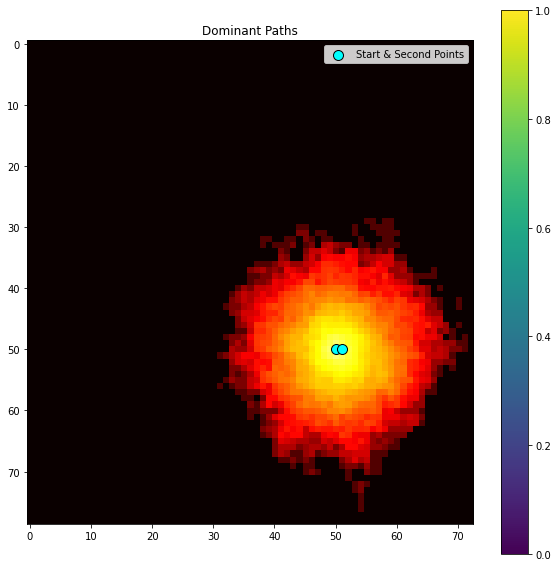

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Assuming HP200 is your DataFrame and paths extraction
amino_acid_length = 50
paths = HP200[(HP200['Amino Acid Length'] == amino_acid_length) & 
              (HP200['Amino Acid Order'].apply(len) > 45)]['Amino Acid Order']
max_x = 0
max_y = 0

for path in paths:
    for _, coord in path:
        x, y = coord
        max_x = max(max_x, x)
        max_y = max(max_y, y)

grid_size_x = max_x + 1
grid_size_y = max_y + 1

frequency_grid = np.zeros((grid_size_x, grid_size_y))

for path in paths:
    for _, coord in path:
        x, y = coord
        frequency_grid[x, y] += 1

frequency_grid[frequency_grid == 0] = np.min(frequency_grid[np.nonzero(frequency_grid)])

# Visualize the frequency grid as a heatmap with a logarithmic color scale
plt.figure(figsize=(10, 10), facecolor='white')  # Adjust as needed for size
plt.imshow(frequency_grid, cmap='hot', norm=LogNorm(), interpolation='nearest')

# Highlight the starting and second points
# Assuming the starting and second points are the same for each path
start_x, start_y = paths.iloc[0][0][1]  # Access the first path's start coordinate
second_x, second_y = paths.iloc[0][1][1]  # Access the first path's second coordinate

plt.scatter([start_y, second_y], [start_x, second_x], color='cyan', s=100, edgecolors='black', label='Start & Second Points', zorder=5)
# Note: plt.scatter() uses (x, y) ordering, so we swap the coordinates for correct positioning

plt.colorbar()
plt.title('Dominant Paths')
plt.legend()
plt.show()


In [21]:
def shorten_direction(direction_list):
    # Create a dictionary mapping full words to their respective initials
    mapping = {'Start': 'S', 'start': 'S', 'middle': 'M', 'right': 'R', 'left': 'L', 'straight': 'S'}
    # Use the mapping to convert each word to its initial and join them into a string
    return ''.join(mapping[direction] for direction in direction_list)

HP200['Full Acid Path'] = HP200['Amino Acid Direction'].apply(lambda x: shorten_direction(x))

In [22]:
# Remove the first two characters from each string (Start and straight)
HP200['Shortened Acid Path'] = HP200['Full Acid Path'].apply(lambda x: x[2:])

In [25]:
# Selecting the specified columns to create smaller dataframe
HP200_small = HP200[['Amino Acid Length', 'Amino Acids on Grid', 'Shortened Acid Path']]
HP200_small.tail()

,Amino Acid Length,Amino Acids on Grid,Shortened Acid Path
39995,200,47,RLRSRSLRRLSSSLLSSRRSSSLLSRSRSLLSSSSLLSRRLRSRR
39996,200,71,SLSLRRSRSLLRLRSSSLSSLSLLRRSSSSSRRLSLRSLRLLRLSR...
39997,200,14,LSLRLRLLSLRL
39998,200,88,SLRSSSLLRLRRLRRLRSSLLRLRLRSRRLLSLSSSSSRLLSRLRR...
39999,200,158,LSSSRLLRRLSLLRSSLRLRRLRSRSSLSSLRSSRLLSSRRLLRSR...


In [24]:
HP200_small.to_csv('../Paper/HP200 small E2.csv', index=False)